In [1]:
%load_ext autoreload
%autoreload 2
from nbutils import chdir_to_root
chdir_to_root()
%pwd

'/home/tornikeo/Documents/work/scalexa/pangeaai/optimize-cosine'

In [2]:
from cudams.utils import argbatch, mkdir
from cudams.data import get_ref_spectra_from_df
from cudams.kernel import compile
from cudams.utils import name2idx
from cudams.cosine import similarity
import math
from pathlib import Path
import pandas as pd
from tqdm import tqdm
from cudams.data import spectra_peaks_to_tensor
from cudams.processor import Config
from numba import cuda
from itertools import product
from time import perf_counter
from multiprocessing.pool import ThreadPool
from multiprocessing import shared_memory
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib

assert cuda.is_available()

In [3]:
## Define constants
tolerance: float = 0.1
shift: float = 0
mz_power: float = 0
int_power: float = 1

## How many pairs per batch. Has to be a power of 2.
# Hardware specific - An RTX2070 works best at around 1024 * 2
# But Colab T4 GPU might work best at 1024 * 4
BATCH_SIZE = 512 * 2

# MAX NUMBER OF PEAKS 
MAX_PEAKS = 1024

# MATCH_LIMIT specifies max how many mz-mz pairs we could consider for each RQ pair, before we sort and filter. 
# E.g. a value of 256 usually causes around ~0.003% of RQ pairs to "overflow".
# The overflown RQ scores will be strictly less than or equal to perfectly accurate score.
# The mean absolute difference at 256, for all overflown pairs is on the order of ~1e-3
# Small values of MATCH_LIMIT (e.g. 128, 64,) cause a dramatic speedup in the processing speed.
MATCH_LIMIT = 1024

## GPU-specific constants
THREADS_PER_BLOCK = (32, 32)
BLOCKS_PER_GRID_X = math.ceil(BATCH_SIZE / THREADS_PER_BLOCK[0])
BLOCKS_PER_GRID_Y = math.ceil(BATCH_SIZE / THREADS_PER_BLOCK[1])
BLOCKS_PER_GRID = (BLOCKS_PER_GRID_X, BLOCKS_PER_GRID_Y)

# Since Greedy cosine is an unstable algorithm, because approximate mz-mz values do not
# result in approximately the same scores and number of matches.
# So we need to use fp64 to minimize the deviation as much as possible.
# Using float32 causes a significant speedup in the processing speed.
dtype = 'float64'

# Data path
reference_csv_file = Path("data/input/test_set_cosine.csv")
query_csv_file = Path("data/input/test_set_cosine.csv")

In [4]:
from cudams.processor import CudaCosineGreedy, CpuCosineGreedy
from collections import defaultdict
from matchms import calculate_scores
from matchms.similarity import CosineGreedy
from tqdm import tqdm
from matchms.filtering import normalize_intensities, select_by_mz, select_by_relative_intensity, reduce_to_number_of_peaks, \
    require_minimum_number_of_peaks
from cudams.utils import mute_stdout

def process_spectrum(spectrum: np.ndarray) -> np.ndarray:
    # spectrum = select_by_mz(spectrum, mz_from=10.0, mz_to=1000.0)
    # spectrum = normalize_intensities(spectrum)
    # spectrum = select_by_relative_intensity(spectrum, intensity_from=0.001)
    # spectrum = reduce_to_number_of_peaks(spectrum, n_max=1000)
    spectrum = reduce_to_number_of_peaks(spectrum, n_max=MAX_PEAKS)
    # spectrum = require_minimum_number_of_peaks(spectrum, n_required=5)
    return spectrum

ref_spectra_df_path = Path(reference_csv_file)
ref_spectra_df = pd.read_csv(ref_spectra_df_path)
references = get_ref_spectra_from_df(ref_spectra_df, 
                                    spectrum_processor=process_spectrum,
                                    limit=BATCH_SIZE,)

query_spectra_df_path = Path(query_csv_file)
query_spectra_df = pd.read_csv(query_spectra_df_path)
queries = get_ref_spectra_from_df(query_spectra_df, 
                                spectrum_processor=process_spectrum,
                                limit=BATCH_SIZE,)

similarity_measure = CosineGreedy(tolerance= 0.1, 
                                mz_power= 0.0, 
                                intensity_power = 1.0)
C_orig = calculate_scores(references, queries, similarity_measure, is_symmetric=True)
Cy = C_orig.to_array()
Cy, Cm = Cy['CosineGreedy_score'], Cy['CosineGreedy_matches']
Cy = np.stack([Cy,Cm],axis=-1)

acum = []
def it(MATCH_LIMIT):
    MATCH_LIMIT = int(MATCH_LIMIT)
    refs = list([r.peaks.to_numpy for r in references])
    ques = list([q.peaks.to_numpy for q in queries])

    rlims = argbatch(refs, BATCH_SIZE)
    qlims = argbatch(ques, BATCH_SIZE)
    R = len(references)
    Q = len(queries)

    batches_rq = list(product(rlims, qlims))

    for (rstart, rend), (qstart, qend) in tqdm(batches_rq, total=len(batches_rq)):
        rspec = refs[rstart:rend]
        qspec = ques[qstart:qend]
        out_true = np.full((BATCH_SIZE, BATCH_SIZE, 2), fill_value=0, dtype='float32')
        for (i, spec1), (j, spec2) in product(enumerate(rspec), enumerate(qspec)):
                score = similarity(
                    spec1,
                    spec2,
                    tolerance=tolerance,
                    shift=shift,
                    mz_power=mz_power,
                    int_power=int_power,
                )
                if score is not None:
                    out_true[i,j,0] = score[0]
                    out_true[i,j,1] = score[1]
        
    C = np.empty((BATCH_SIZE,BATCH_SIZE,2), dtype='float32')
    C[:] = out_true[:]
    
    cosine = CudaCosineGreedy(
                tolerance=.1,
                mz_power=0,
                intensity_power=1, 
                shift=0,
                batch_size=BATCH_SIZE,
                match_limit=MATCH_LIMIT,
            )
    cosine.compile()
    G, Ov = cosine.matrix(
        references=references, 
        queries=queries, 
        array_type="numpy"
    )
    R,Q,_ = Cy.shape
    return MATCH_LIMIT, C[:R,:Q],G[:R,:Q],Cy[:R,:Q],Ov[:R,:Q]

from joblib import Parallel, delayed

acum = Parallel(n_jobs=6)(
    delayed(
       it 
    )(MATCH_LIMIT)
    for MATCH_LIMIT in tqdm(np.linspace(128, 4096, 18, dtype='int32'))
)

100%|██████████| 1/1 [00:25<00:00, 25.37s/it]]
Batch all references: 1it [00:00, 26.71it/s]
Batch all queries: 1it [00:00, 26.45it/s]
100%|██████████| 1/1 [00:26<00:00, 26.02s/it]
Batch all references: 1it [00:00, 28.63it/s]
Batch all queries: 1it [00:00, 33.31it/s]
100%|██████████| 1/1 [00:25<00:00, 25.80s/it]
Batch all references: 1it [00:00, 22.66it/s]
Batch all references: 1it [00:00, 26.05it/s]
Batch all queries: 1it [00:00, 29.47it/s]
Batch all queries: 1it [00:00, 28.71it/s]
100%|██████████| 1/1 [00:27<00:00, 27.44s/it]
Batch all references: 1it [00:00, 31.64it/s]
Batch all queries: 1it [00:00, 30.63it/s]
100%|██████████| 1/1 [00:27<00:00, 27.19s/it]
Batch all references: 1it [00:00, 29.82it/s]
Batch all queries: 1it [00:00, 33.38it/s]
100%|██████████| 1/1 [00:14<00:00, 14.39s/it]
Batch all references: 1it [00:00, 22.11it/s]
Batch all queries: 1it [00:00, 19.96it/s]
100%|██████████| 1/1 [00:14<00:00, 14.29s/it]
Batch all references: 1it [00:00, 34.35it/s]
Batch all queries: 1it 

In [7]:
x = []
y = []

R, Q = BATCH_SIZE, BATCH_SIZE

for MATCH_LIMIT, C, G, Cy, Ov in acum:
    y_row = []
    print('MATCH_LIMIT', MATCH_LIMIT)

    C_match = np.isclose(Cy[:R,:Q], G[:R,:Q])
    corr = C_match.mean()
    print("CPU orig vs GPU accuracy:", corr)
    y_row.append(corr)
    
    C_match = np.isclose(C[:R,:Q], G[:R,:Q])
    corr = C_match.mean()
    # print("Overflows", Ov[:R,:Q].mean())
    # print("CPU opt vs GPU:", corr)
    y_row.append(corr)

    C_match = np.isclose(Cy[:R,:Q], C[:R,:Q])
    corr = C_match.mean()
    # print("CPU orig vs CPU opt", corr)
    y_row.append(corr)
    
    y_row.append(1-Ov.mean())
    
    y.append(y_row)
    x.append(MATCH_LIMIT)

MATCH_LIMIT 128
CPU orig vs GPU accuracy: 0.9855294227600098
MATCH_LIMIT 361
CPU orig vs GPU accuracy: 0.9991497993469238
MATCH_LIMIT 594
CPU orig vs GPU accuracy: 0.9998059272766113
MATCH_LIMIT 828
CPU orig vs GPU accuracy: 0.999931812286377
MATCH_LIMIT 1061
CPU orig vs GPU accuracy: 0.9999537467956543
MATCH_LIMIT 1295
CPU orig vs GPU accuracy: 0.9999628067016602
MATCH_LIMIT 1528
CPU orig vs GPU accuracy: 0.9999709129333496
MATCH_LIMIT 1761
CPU orig vs GPU accuracy: 0.9999861717224121
MATCH_LIMIT 1995
CPU orig vs GPU accuracy: 0.9999899864196777
MATCH_LIMIT 2228
CPU orig vs GPU accuracy: 0.9999961853027344
MATCH_LIMIT 2462
CPU orig vs GPU accuracy: 0.9999961853027344
MATCH_LIMIT 2695
CPU orig vs GPU accuracy: 0.9999961853027344
MATCH_LIMIT 2928
CPU orig vs GPU accuracy: 0.9999961853027344
MATCH_LIMIT 3162
CPU orig vs GPU accuracy: 0.9999980926513672
MATCH_LIMIT 3395
CPU orig vs GPU accuracy: 0.9999980926513672
MATCH_LIMIT 3629
CPU orig vs GPU accuracy: 0.9999980926513672
MATCH_LIMIT 3

Text(0.5, 0, 'MATCH_LIMIT')

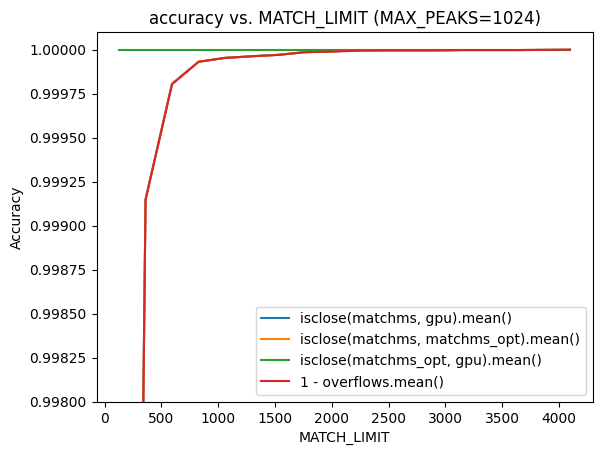

In [11]:
plt.plot(x,np.array(y))
plt.ylim([.998,1.0001])
plt.title(f"accuracy vs. MATCH_LIMIT (MAX_PEAKS={MAX_PEAKS})")
plt.legend(['isclose(matchms, gpu).mean()',
            'isclose(matchms, matchms_opt).mean()',
            'isclose(matchms_opt, gpu).mean()',
            "1 - overflows.mean()"])
plt.ylabel("Accuracy")
plt.xlabel("MATCH_LIMIT")